### **Connect to Google Drive**

In [1]:
from google.colab import drive;
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


# **From Vanilla 2-layer MLP to Deep MLPs**



To turn our “vanilla” 2-layer MLP into a truly deep feed-forward net, we basically need to:

1. Increase the depth (number of hidden layers)
2. Potentially add architectural “plumbing” like Batch Normalization or even residual (“skip”) connections to keep gradients flowing
3. Use stronger initializers (e.g. He initialization for ReLUs)
4. Optionally swap in more expressive activations (e.g. GELU or Swish)
5. Extend your hyperparameter search to span these new dimensions

We are going to construct at deep feed forward network (FFN). A lot of techniques can be used, but since proprocessing, tuning and training is not the goal of the thesis, we keep this fairly breif and simplictic.


High level notebook structure:
1.  Import data and prepare related functions.
2.  Create rough baseline model.
3.  Perform model search to find a model that represents this architecture well.
4.  Fully train best model found.
5.  Evaluate and save fully trained model.


3 is an important step which can be analysed thoroughly in order to extract the most signal from data. **However**, this is not our research topic, so we use the following approach (high level description, see relevant section for further).
1. Set most parameters (hyperparameters, training parameters and architecture parameters to defaults).
2. From pior knowledge define ~5 parameters that will be tuned (most important parameters).
3. Conduct a 60 trial search over defined space (using median pruner to ease computational costs whilst preserving enough models, and RandomSampler).
4. Analyse parameter frequency in best performing trials, and freeze most _dominant_ parameters.
5. Repeat 3-4 until no clear parameter-pattern can be observed from best performing trials.
6. Tune basis model (derrived from 3-5) with pruning (again to ease computational costs). If more than one trial survives the the model confidence set is used to identify the _best_ model.



# **Data Ingestion & Preprocessing Pipeline**

Import data, seperate into features and labels, convert into tensorflow dataset, and split into test, validation and train data.

## **Load and split data**

Data is imported after rough data clean (see notebooks in Data folder).

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load data and sort by eom
securities_data = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Kopi af data_stock_returns_final.parquet')
securities_data = securities_data.sort_values('eom')


# List of features
features = [
    feat for feat in securities_data.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
]


# Time-based split
months = sorted(securities_data['eom'].unique())
n = len(months)
splits = [int(n * 0.7), int(n * 0.85)]

month_bins = [
    months[:splits[0]],             # Train
    months[splits[0]:splits[1]],    # Validation
    months[splits[1]:],             # Test
]


# Create datasets
datasets = [
    securities_data[securities_data['eom'].isin(m)] for m in month_bins
]


# Create datasets
X_train, y_train = datasets[0][features].values.astype('float32'), datasets[0]['ret_exc_lead1m'].values.astype('float32')
X_val, y_val     = datasets[1][features].values.astype('float32'), datasets[1]['ret_exc_lead1m'].values.astype('float32')
X_test, y_test   = datasets[2][features].values.astype('float32'), datasets[2]['ret_exc_lead1m'].values.astype('float32')

Remove unnessecary variables

In [4]:
%who

X_test	 X_train	 X_val	 datasets	 drive	 features	 month_bins	 months	 n	 
np	 pd	 securities_data	 splits	 y_test	 y_train	 y_val	 


In [5]:
del securities_data, datasets, features

Building our design matrix X and response y for a supervised regression problem.
The label used is `ret_exc_lead1m` (next months excess returns).

we’re predicting next‐month excess return (ret_exc_lead1m) from a vector of firm characteristics (list_primary_features)

# **Baseline model (might delete later)**

As recommended in the *deep learning book* a reasonable baseline model is created.

|       Parameter       |             Type            |                              Reason                              |
|:---------------------:|:---------------------------:|:----------------------------------------------------------------:|
| Architecture          | Feed forward neural network | The NN studied here                                              |
| Input                 | $X \in \mathbb{R}^{195}$    | Shape of features.                                               |
| # Hidden Layers       | 2 Dense                     | Simplicity                                                       |
| # Units               | [64,32]                     | Reduction: helps generalize.                                     |
| Activations           | [ReLu, tanh]                | ReLu: Standard. tanh: pos./neg. output.                         |
| Output Layer          | None (Linear)               | Real valued predictions.                                         |
| Loss                  | Mean Squared Error (MSE)    | Statistically best with Gaussian noise.                          |
| Optimizer             | Adam                        | Sparse gradients and adaptive learning rates: good at noisy data |
| Learning Rate         | 0.001                       | Default Adam: Stable convergence.                                |
| Batch Size            | 64                          | GPU efficiency.                                                  |
| Epochs                | 60 + early stopping         | Efficiency + does not overfit.                                   |
| Dropout               | 0.2                         | Regularization of noisy domain.                                  |
| Weight Regularization | $L_2$ and $\lambda = 1e-4$    | Weights small, reduce sensitivity to noise.                      |

## **Build Baseline Model**

The baseline model is created below.
A feed-forward neural network (a.k.a. multilayer perceptron) with two hidden layers of width 50, ReLU activations .
ReLU mitigates vanishing‐gradient issues compared to sigmoids .
We optimize MSE (mean squared error), which corresponds to maximum‐likelihood under Gaussian noise , and report MAE as an interpretable auxiliary metric.

In [ ]:
# Load packages
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

In [ ]:
# Baseline model
ffn_baseline = tf.keras.Sequential([
    # Input layer

    tf.keras.layers.Input(shape=(X_test.shape[1], )),

    # 1'st hidden layer
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # 2'nd hidden layer
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # 3'nd hidden layer
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(rate=0.25),

    # Output layer
    tf.keras.layers.Dense(1, activation='linear')
])

In [ ]:
ffn_baseline.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mse', 'mae']
)

In [ ]:
# Create early stopping callback
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    restore_best_weights=True
)


# Train model
ffn_baseline_history = ffn_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=60,
    callbacks=[earlystop_cb],
    verbose=1
)

Epoch 1/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.0852 - mae: 0.2956 - mse: 0.2324 - val_loss: 0.0406 - val_mae: 0.0675 - val_mse: 0.0095
Epoch 2/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0325 - mae: 0.0873 - mse: 0.0177 - val_loss: 0.0105 - val_mae: 0.0676 - val_mse: 0.0095
Epoch 3/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0175 - mae: 0.0867 - mse: 0.0171 - val_loss: 0.0095 - val_mae: 0.0675 - val_mse: 0.0095
Epoch 4/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0181 - mae: 0.0869 - mse: 0.0181 - val_loss: 0.0096 - val_mae: 0.0684 - val_mse: 0.0096
Epoch 5/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0174 - mae: 0.0866 - mse: 0.0174 - val_loss: 0.0097 - val_mae: 0.0689 - val_mse: 0.0097
Epoch 6/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0178 - mae: 0.0866 - mse: 0.0178 - val_loss: 0.0096 - val_mae: 0.0682 - val_mse: 0.0096
Epoch 7/60
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0171 - mae: 0.0865 - ms

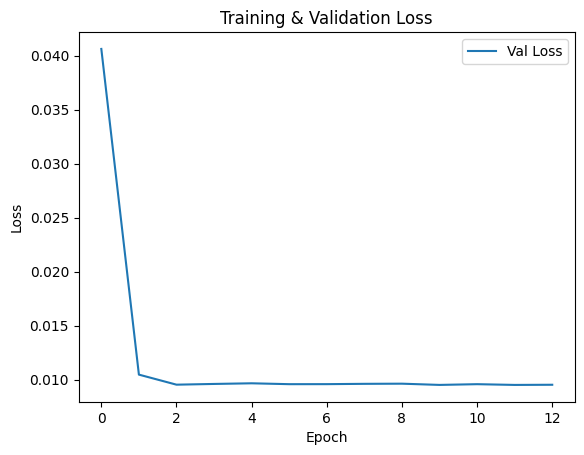

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ffn_baseline_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [ ]:
ffn_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,181 (180.40 KB)

 Trainable params: 15,393 (60.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,788 (120.27 KB)

In [ ]:
ffn_baseline.save('ffn_baseline.keras')

In [ ]:
ffn_baseline.evaluate(X_val, y_val, verbose=1)

1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0080 - mae: 0.0630 - mse: 0.0079


[0.009538541547954082, 0.009515351615846157, 0.06754966825246811]

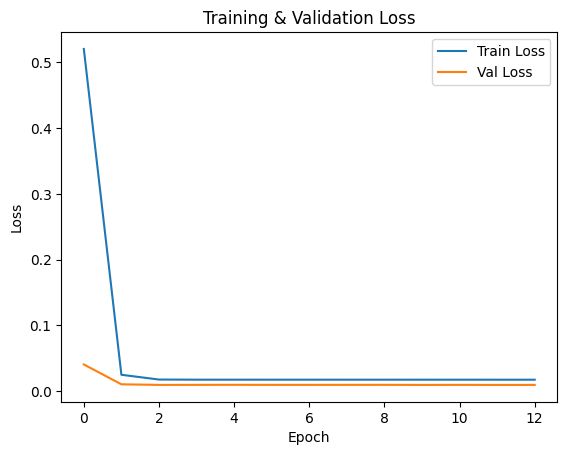

In [ ]:
plt.plot(ffn_baseline_history.history['loss'], label='Train Loss')
plt.plot(ffn_baseline_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# **Deep Feed Forward Neural Network Model Search Workflow**

The probability that a trial is not in the 5th quantile is $P_{\text{fail}} = 1 - 0.05$, and the probability that $N$ trials all fail is $P_{\text{all fail}} = (1-0.05)^N$. The probability that at least one trial is in the 5th quantile is:
  
$$
1 - (1-0.05)^N |_{N=60} \approx 0.95383
$$

Thus, at least 60 trials are needed to ensure one is in the 5th quantile.

Using this, the model search workflow becomes:
1. 60 trail random search.
2. Sensitivity analysis using f-ANOVA to select HP's with cumulative importance $\geq 80\%$.
3. Focused search on winners of 1 and 2. Random sample.


The baseline is fixed at two layers of 50 units with lr=1e-3. We now search over:
number of layers (1–3)
hidden units (10–100 each)
dropout rates (0–0.5 each)
activation (ReLU or tanh)
optimizer (Adam, RMSprop, SGD)
learning rate (log-uniform between 1e-5 and 1e-2)

## **Seach strategy**

We will tune the following parameters
1. Number of units
2. Number of hidden layers (following a pyramid structure)
3. Optimizer used (adam or sgd)
4. Batch size
5. Learning rate
6. L2 regulizer (and factor if picked)

In addition the models will always use
- ReLU activation functions (standard activation function).
- Layer normalisation.
- Last hidden layer tanh.
- Dropout rate (prevents co-adaptation of neurons).


Instead of creating a new function every time i will make a function that allows me to iteratively freeze variables.


## **Changes from Vanilla FFNN to Deep FFNN**


## **1. First search**

#### Comments
**Layer Normalization** normalizes the activations across the features (neurons) in each layer for each individual data sample, while **Batch Normalization** normalizes across the batch dimension for each feature.

Layer Normalization:
- Normalizes across the features.
- More suitable for Recurrent Neural Networks (RNNs).
- Independent of batch size.

Batch Normalization:
- Normalizes across the batch for each feature.
- Works well with Feedforward Neural Networks (FNNs).
- Adds a bit of regularization and reduces overfitting.
- Helps reduce internal covariate shift.

Since the architecture is a deep feedforward neural network (25–60 layers), Batch Normalization is empirically more effective.

In [6]:
!pip install -q optuna==3.4.0
!pip install -q optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 9.0 MB/s eta 0:00:00


In [7]:
import matplotlib.pyplot as plt
import optuna

import joblib

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation, Add
)
from tensorflow.keras.regularizers import l2


Below we deinfe some variables:

SEED =  The seed is used to ensure reproducibility. Random operations in training (like weight initialisation, dropout masking, or data shuffling) become deterministic when seeded. The value 42 is arbitrarily chosen—popularised as a cultural reference (e.g. The Hitchhiker’s Guide to the Galaxy) but more importantly it is fixed to ensure that every time the code runs, the random search over the hyperparameter space yields the same sequence of sampled configurations.

MAX_EPOCHS = This defines the maximum number of times the neural network sees the entire training dataset during training (i.e. a full forward and backward pass). Here, 20 is a coarse early stopping threshold, keeping training time manageable for each configuration sampled during the hyperparameter search. Deep models take longer to converge, but since this is a coarse search (initial sweep over the space), short training avoids overfitting and saves compute.

N_TRIALS = This controls how many distinct random configurations of hyperparameters (architecture, optimisers, dropout, etc.) are tested. Each trial samples a configuration, trains it, and evaluates validation loss.

In [8]:
SEED          = 42

N_TRAILS      = 60
MAX_EPOCHS    = 30

INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

### **1.1. Model builder**

**Model builder function**
Dropout randomly deactivates units at each update; it’s a powerful regularizer for deep nets .
Varying activation functions can affect gradient flow (ReLU vs. tanh) .
Learning rate and optimizer choice control convergence speed and stability.

The **order of operations** is: Dense → Activation → BatchNormalization → Dropout

**Dropout** = Dropout is a regularisation technique introduced to prevent co-adaptation of units. For deep architectures, dropout encourages redundancy, improves generalisation, and combats overfitting.

**Callbacks** = Callbacks in Keras are hooks executed during training, including EarlyStopping: Monitors validation loss and stops training if it does not improve for a given number of epochs (patience), and ModelCheckpoint: Saves the best model parameters during training. Together, callbacks avoid unnecessary training and help recover the best version of the model.

**Negative slope** = This term usually appears in Leaky ReLU activation functions, where alpha in [0,1] is the negative slope.  It addresses the “dying ReLU” problem by allowing a small gradient for negative inputs.

**Linear activation in final layer** = For regression, the output is a real-valued scalar, and a linear activation function is identity and permits the model to output unbounded continuous values, which is appropriate for financial return prediction. Using nonlinear functions like sigmoid or tanh would bound predictions, making them inappropriate here.

**Verbose** = (træningsomfang) controls the verbosity of training output:
0: silent, 1: progress bar, 2: one line per epoch.
This is for monitoring training progress. For deep networks, verbose=1 is typically used for real-time feedback.


**BatchNorm** = normalises activations layer-wise during training. It stabilises training dynamics, allows higher learning rates, reduces need for dropout (but both can be combined). BatchNorm is vital in very deep nets where even small changes in initial conditions can cause training divergence.


**Width Decay** = A deep FFNN with constant width is inefficient and over-parameterised. Inspired by the geometric pyramid rule (as in Goodfellow et al., Ch. 6.4.1) yields early layers: high-dimensional, capture low-level features, deeper layers: compact, extract abstract features, and lower variance in gradients.

**Residual (Skip) Connections** =  In deep networks (e.g. 50+ layers), gradients can vanish due to repeated application of nonlinear functions. A residual block solves this.

In [ ]:
def create_model(trial: optuna.Trial):
    # Units and layers
    n_units = trial.suggest_categorical('n_units', [32, 64, 128, 256])
    n_layers = trial.suggest_categorical('n_layers', [25, 30, 35, 40, 50, 55, 60])

    # Regularizer
    bool_l2 = trial.suggest_categorical('bool_l2', [True, False])
    l2_fac = trial.suggest_float('l2_fac', 1e-4, 1e-2, log=True) if bool_l2 else None
    l2_reg = tf.keras.regularizers.L2(l2_fac) if bool_l2 else None

    # He Initialization
    initializer = tf.keras.initializers.HeNormal()

    # Create model
    model = tf.keras.Sequential()    # <- Removed unnecessary indent
    model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(n_units,
                                        activation='relu',
                                        kernel_initializer=initializer,
                                        kernel_regularizer=l2_reg))
        model.add(tf.keras.layers.LayerNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.25))

    model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear', kernel_regularizer=l2_reg))

    return model


### **1.2. Objective function**

In [ ]:
def warmup_schedule(epoch, lr):
    # Warm-up for the first 5 epochs
    if epoch < 5:
        return lr * (epoch + 1) / 5
    else:
        return lr

In [ ]:
def objective(trial: optuna.Trial):
    # Learning related HP's
    bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    opt = trial.suggest_categorical('opt', ['adam', 'sgd'])

    if opt == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    if opt == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Retrieve and compile models
    model = create_model(trial)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

    # Callbacks
    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=5,
        restore_best_weights=True
    )

    pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

    # Learning Rate Warm-Up
    lr_warmup_cb = tf.keras.callbacks.LearningRateScheduler(warmup_schedule)

    # Train model
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=bs,
        callbacks=[pruning_cb, earlystop_cb, lr_warmup_cb],
        verbose=0
    )

    return model.evaluate(X_val, y_val, verbose=0)[0]


### **1.3. Sampler and run Study**

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=3,
    interval_steps=1,
)

first_search = optuna.create_study(
    direction='minimize',
    study_name='first_search',
    sampler=sampler,
    pruner=pruner,
    storage='sqlite:////content/drive/MyDrive/Colab Notebooks/Studies/first_study_25-60Layers.db',
    load_if_exists=True
)

first_search.optimize(objective, n_trials=N_TRAILS)

[I 2025-05-07 12:02:15,552] A new study created in RDB with name: first_search
[I 2025-05-07 12:12:22,592] Trial 0 finished with value: 2.797636032104492 and parameters: {'bs': 64, 'lr': 2.9380279387035334e-05, 'opt': 'adam', 'n_units': 32, 'n_layers': 25, 'bool_l2': True, 'l2_fac': 0.0016738085788752138}. Best is trial 0 with value: 2.797636032104492.
[I 2025-05-07 12:16:10,217] Trial 1 finished with value: 8.944068908691406 and parameters: {'bs': 256, 'lr': 0.0022673986523780395, 'opt': 'sgd', 'n_units': 128, 'n_layers': 35, 'bool_l2': True, 'l2_fac': 0.0009780337016659412}. Best is trial 0 with value: 2.797636032104492.
[I 2025-05-07 12:26:54,672] Trial 2 finished with value: 20.967466354370117 and parameters: {'bs': 64, 'lr': 8.612579192594876e-05, 'opt': 'sgd', 'n_units': 64, 'n_layers': 35, 'bool_l2': True, 'l2_fac': 0.004544383960336014}. Best is trial 0 with value: 2.797636032104492.
[I 2025-05-07 12:38:13,840] Trial 3 finished with value: 56.954261779785156 and parameters: {'b

### **1.4. Evaluate**

In [9]:
first_search = optuna.load_study(
    study_name='first_search',
    storage='sqlite:////content/drive/MyDrive/Colab Notebooks/Studies/first_study_25-60Layers.db'
)

We now evaluate the top 20% best performing models and look at patterns in their parameters.

In [10]:
# Get all complete trials and sort
first_search_df = first_search.trials_dataframe()
first_search_df = first_search_df[first_search_df['state'] == 'COMPLETE']
first_search_df = first_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
first_search_df = first_search_df.sort_values(by='value')

# Get best trials
first_search_best_trials = first_search_df.head(int(0.2 * len(first_search_df)))
first_search_best_trials

,number,value,params_bool_l2,params_bs,params_l2_fac,params_lr,params_n_layers,params_n_units,params_opt
18,18,0.009516,False,64,NaN,0.003811,40,64,adam
32,32,0.009516,False,32,NaN,0.001830,25,64,adam
22,22,0.009518,False,256,NaN,0.003496,40,64,adam
13,13,0.009524,False,32,NaN,0.008266,50,64,adam
49,49,0.009527,False,32,NaN,0.003076,55,64,sgd
7,7,0.009527,False,32,NaN,0.005306,25,64,adam
12,12,0.009527,False,32,NaN,0.009448,50,256,adam


## **2. Second search**

### **2.1. Model builder**

In [ ]:
def create_model_2(trial: optuna.Trial):
    # Units and layers
    n_units = trial.suggest_categorical('n_units', [32, 64, 128, 256])
    n_layers = trial.suggest_categorical('n_layers', [25, 30, 35, 40, 50, 55, 60])


    # He Initialization
    initializer = tf.keras.initializers.HeNormal()

    # Create model
    model = tf.keras.Sequential()    # <- Removed unnecessary indent
    model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(n_units,
                                        activation='relu',
                                        kernel_initializer=initializer,
                                        ))
        model.add(tf.keras.layers.LayerNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.25))

    model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear'))

    return model


### **2.2. Objective function**

In [ ]:
def warmup_schedule(epoch, lr):
    # Warm-up for the first 5 epochs
    if epoch < 5:
        return lr * (epoch + 1) / 5
    else:
        return lr

In [ ]:
def objective_2(trial: optuna.Trial):
    # Learning related HP's
    bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    opt = trial.suggest_categorical('opt', ['adam', 'sgd'])

    if opt == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    if opt == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Retrieve and compile models
    model = create_model_2(trial)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

    # Callbacks
    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=5,
        restore_best_weights=True
    )

    pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

    # Learning Rate Warm-Up
    lr_warmup_cb = tf.keras.callbacks.LearningRateScheduler(warmup_schedule)

    # Train model
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=bs,
        callbacks=[pruning_cb, earlystop_cb, lr_warmup_cb],
        verbose=0
    )

    return model.evaluate(X_val, y_val, verbose=0)[0]

### **2.3. Sampler and run Study**

In [ ]:
sampler = optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=48)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,
    n_warmup_steps=3,
    interval_steps=1,
)

second_search = optuna.create_study(
    direction='minimize',
    study_name='2_second_search',
    sampler=sampler,
    pruner=pruner,
    storage='sqlite:////content/drive/MyDrive/Colab Notebooks/Studies/2_second_study_25-60Layers.db',
    load_if_exists=True
)

second_search.optimize(objective_2, n_trials=N_TRAILS)

[I 2025-05-08 04:43:19,418] Using an existing study with name '2_second_search' instead of creating a new one.
[I 2025-05-08 04:45:22,831] Trial 5 finished with value: 0.009517267346382141 and parameters: {'bs': 128, 'lr': 0.009373120299901597, 'opt': 'adam', 'n_units': 256, 'n_layers': 25}. Best is trial 5 with value: 0.009517267346382141.
[I 2025-05-08 04:48:36,685] Trial 6 finished with value: 1.6280981302261353 and parameters: {'bs': 128, 'lr': 1.990858903149304e-05, 'opt': 'sgd', 'n_units': 256, 'n_layers': 50}. Best is trial 5 with value: 0.009517267346382141.
[I 2025-05-08 05:24:14,945] Trial 7 finished with value: 0.009610757231712341 and parameters: {'bs': 32, 'lr': 7.472983122061668e-05, 'opt': 'adam', 'n_units': 256, 'n_layers': 55}. Best is trial 5 with value: 0.009517267346382141.
[I 2025-05-08 05:26:35,087] Trial 8 finished with value: 0.36677414178848267 and parameters: {'bs': 128, 'lr': 9.899375404432212e-05, 'opt': 'sgd', 'n_units': 64, 'n_layers': 35}. Best is trial 5

### **2.4. Evaluate**

In [11]:
second_search = optuna.load_study(
    study_name='2_second_search',
    storage='sqlite:////content/drive/MyDrive/Colab Notebooks/Studies/2_second_study_25-60Layers.db'
)

We now evaluate the top 20% best performing models and look at patterns in their parameters.

In [12]:
# Get all complete trials and sort
second_search_df = second_search.trials_dataframe()
second_search_df = second_search_df[second_search_df['state'] == 'COMPLETE']
second_search_df = second_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
second_search_df = second_search_df.sort_values(by='value')

# Get best trials
second_search_best_trials = second_search_df.head(int(0.2 * len(first_search_df)))
second_search_best_trials

,number,value,params_bs,params_lr,params_n_layers,params_n_units,params_opt
67,67,0.009514,32,0.003561,25.0,256.0,sgd
76,76,0.009515,32,0.006645,30.0,256.0,sgd
107,107,0.009515,128,0.005203,55.0,128.0,sgd
13,13,0.009515,32,0.005233,40.0,128.0,sgd
101,101,0.009515,32,0.004698,55.0,128.0,sgd
121,121,0.009516,32,0.006549,55.0,128.0,sgd
97,97,0.009516,32,0.003468,55.0,128.0,sgd


## **3. Third and Final search**

For the final search we decrease the `min_delta` and patience in order to let the model run longer. Additionally we increase `n_warmup_steps` and `n_startup_trials` for median pruner to evaluate more mature models.

### **3.1 Model Builder**

In [ ]:
# Global variables
SEED          = 42
N_TRAILS      = 100
MAX_EPOCHS    = 45
INPUT_SHAPE   = (X_train.shape[1],)
OUTPUT_SHAPE  = 1

!pip install -q optuna==3.4.0
!pip install -q optuna-integration
import tensorflow as tf
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 9.2 MB/s eta 0:00:00


In [ ]:
def create_model_3(trial: optuna.Trial):
    # Units and layers
    n_units = trial.suggest_categorical('n_units', [32, 64, 128, 256])
    n_layers = trial.suggest_categorical('n_layers', [25, 30, 35, 40, 50, 55, 60])


    # He Initialization
    initializer = tf.keras.initializers.HeNormal()

    # Create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(n_units,
                                        activation='relu',
                                        kernel_initializer=initializer,
                                        ))
        model.add(tf.keras.layers.LayerNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.25))

    model.add(tf.keras.layers.Dense(OUTPUT_SHAPE, activation='linear'))

    return model


### **3.2. Objective function**

We now define a function that retrives the **objective function (i.e. the loss).**
TPE search over a high‐dimensional hyperparameter space has been shown to outperform random search in many cases .
We minimize validation MSE to pick the hyperparameters that best generalize.
The objective function defines how each trial (a sampled combination of hyperparameters) is evaluated and scored, allowing Optuna to explore the hyperparameter space efficiently.

The search space variables form part of the search space, and Optuna randomly (or via TPE) samples them for each trial.

In [ ]:
def warmup_schedule(epoch, lr):
    # Warm-up for the first 5 epochs
    if epoch < 5:
        return lr * (epoch + 1) / 5
    else:
        return lr

In [ ]:
def objective_3(trial: optuna.Trial):
    # Learning related HP's
    bs = trial.suggest_categorical('bs', [32, 64, 128, 256])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    opt = trial.suggest_categorical('opt', ['adam', 'sgd'])

    if opt == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    if opt == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Retrieve and compile models
    model = create_model_3(trial)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])

    # Callbacks
    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-5,
        patience=10,
        restore_best_weights=True
    )

    pruning_cb = optuna.integration.KerasPruningCallback(trial, "val_loss")

    # Learning Rate Warm-Up
    lr_warmup_cb = tf.keras.callbacks.LearningRateScheduler(warmup_schedule)

    # Train model
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=bs,
        callbacks=[pruning_cb, earlystop_cb, lr_warmup_cb],
        verbose=0
    )

    return model.evaluate(X_val, y_val, verbose=0)[0]

### 3.3. **Sampler and Run study**

We now run the study using random sampling, which is in fact superior to grid search and often better than early-stage Bayesian methods (e.g. TPE) in high-dimensional, conditional search spaces like this. We are searching over both architectural and regularization hyperparameters, including:
- layer depth n_layers ∈ [25, 50]
- activation types
- dropout usage and rate
- L2 regularisation
- Leaky ReLU slope

**Random sampler** = samples hyperparameters from discrete lists or log-normal distributions (for continuous params like learning rate). This is favourable because: For high-dimensional hyperparameter spaces (like layer sizes in 25–50 depth), random search explores more effectively than grid search (Bergstra & Bengio, 2012), and random sampling avoids combinatorial explosion. Random sampling is recommended in the exploratory phase (coarse tuning). Once coarse regions are found (e.g. 30–35 layers outperform others), a fine-tuned search using TPE can follow.

**TPE sampler** = a Tree-structured Parzen Estimator (TPE) sampler is a Bayesian optimiser. It models the probability of low-loss configurations given hyperparameters, and uses an acquisition function to suggest the next best trial. However, TPE requires more time per iteration (due to posterior updates and modelling the objective function), and therefore TPE is only recommended if you have sufficient compute budget and aim for fine-tuned performance.

In [ ]:
sampler = optuna.samplers.TPESampler(n_startup_trials=20, n_ei_candidates=48)
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=20,
    n_warmup_steps=6,
    interval_steps=1,
)

final_search = optuna.create_study(
    direction='minimize',
    study_name='final_search',
    sampler=sampler,
    pruner=pruner,
    storage='sqlite:////content/drive/MyDrive/Colab Notebooks/Studies/final_study_25-60Layers.db',
    load_if_exists=True
)

second_search.optimize(objective_3, n_trials=N_TRAILS)

[I 2025-05-08 09:41:12,177] A new study created in RDB with name: final_search
[I 2025-05-08 09:42:47,325] Trial 65 pruned. Trial was pruned at epoch 0.
[I 2025-05-08 09:43:52,333] Trial 66 pruned. Trial was pruned at epoch 0.
[I 2025-05-08 09:49:27,307] Trial 67 finished with value: 0.009513969533145428 and parameters: {'bs': 32, 'lr': 0.003560634290807478, 'opt': 'sgd', 'n_units': 256, 'n_layers': 25}. Best is trial 67 with value: 0.009513969533145428.
[I 2025-05-08 09:50:59,393] Trial 68 pruned. Trial was pruned at epoch 1.
[I 2025-05-08 09:52:02,341] Trial 69 pruned. Trial was pruned at epoch 0.
[I 2025-05-08 10:08:13,097] Trial 70 finished with value: 0.00952490046620369 and parameters: {'bs': 32, 'lr': 0.005490804939769301, 'opt': 'sgd', 'n_units': 256, 'n_layers': 60}. Best is trial 67 with value: 0.009513969533145428.
[I 2025-05-08 10:09:15,710] Trial 71 pruned. Trial was pruned at epoch 0.
[I 2025-05-08 10:10:45,099] Trial 72 pruned. Trial was pruned at epoch 0.
[I 2025-05-08 

### 3.4. **Evaluate final study**

In [19]:
final_search = optuna.load_study(
    study_name='second_search',
    storage='sqlite:////content/drive/MyDrive/Colab Notebooks/Studies/second_study_25-60Layers.db'
)

In [20]:
final_search_df = final_search.trials_dataframe()


In [21]:
# Get all complete trials and sort
final_search_df = final_search_df[final_search_df['state'] == 'COMPLETE']
final_search_df = final_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
final_search_df = final_search_df.sort_values(by='value')

# Get best trials
final_search_best_trials = final_search_df.head(int(0.2 * len(final_search_df)))
final_search_best_trials

,number,value,params_bool_l2,params_bs,params_l2_fac,params_lr,params_n_layers,params_n_units,params_opt
25,25,0.009519,False,64,NaN,0.000924,50,128,adam
31,31,0.009521,False,64,NaN,0.000842,50,128,adam
21,21,0.009521,False,64,NaN,0.000597,60,128,adam
23,23,0.009522,False,64,NaN,0.000586,50,128,adam
27,27,0.009527,False,64,NaN,0.000841,50,128,adam


In [14]:
from typing_extensions import Final
# Get all complete trials and sort
final_search_df = final_search.trials_dataframe()
final_search_df = final_search_df[final_search_df['state'] == 'COMPLETE']
final_search_df = final_search_df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
final_search_df = final_search_df.sort_values(by='value')

# Get best trials
final_search_best_trials = final_search_df.head(int(0.2 * len(final_search_df)))
final_search_best_trials


KeyError: 'state'

In [ ]:
final_search.best_params

{'bs': 32,
 'lr': 0.003560634290807478,
 'opt': 'sgd',
 'n_units': 256,
 'n_layers': 25}

## **4. Final model**
We now build the final model with
- batch size: 32,
- learning rate: 0.003560634290807478,
- optimizer: 'sgd',
- number of units per layer: 256,
- number of layers: n_layers': 25

The final model is created below and trained (with same early-stopping callback as before).

In [ ]:
import tensorflow as tf

def build_deep_ffnn(input_shape, learning_rate=0.003560634290807478):

    # Initialize the model
    dffn_final = tf.keras.Sequential()

    # Input layer
    dffn_final.add(tf.keras.Input(shape=(input_shape, )))

    # Hidden layers (25 layers of 256 units each)
    for _ in range(25):
        dffn_final.add(tf.keras.layers.Dense(256,
                                             activation='relu',
                                             kernel_initializer=tf.keras.initializers.HeNormal()))
        dffn_final.add(tf.keras.layers.LayerNormalization())
        dffn_final.add(tf.keras.layers.Dropout(0.25))

    # Output layer
    dffn_final.add(tf.keras.layers.Dense(1, activation='linear'))

    # Compile the model
    dffn_final.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss='mse',
        metrics=['mse', 'mae']
    )

    return dffn_final

The model is trained below.

In [ ]:
# Instantiate the model
dffn_model = build_deep_ffnn(X_train.shape[1])

# Define early stopping callback
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5,
    patience=10,
    restore_best_weights=True
)

# Train the model
dffn_history = dffn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,   # As per hyperparameter search
    epochs=60,
    callbacks=[earlystop_cb],
    verbose=1
)


Epoch 1/60
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.1651 - mae: 0.2086 - mse: 0.1651 - val_loss: 0.0095 - val_mae: 0.0675 - val_mse: 0.0095
Epoch 2/60
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0178 - mae: 0.0897 - mse: 0.0178 - val_loss: 0.0098 - val_mae: 0.0697 - val_mse: 0.0098
Epoch 3/60
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0178 - mae: 0.0893 - mse: 0.0178 - val_loss: 0.0096 - val_mae: 0.0676 - val_mse: 0.0096
Epoch 4/60
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0184 - mae: 0.0900 - mse: 0.0184 - val_loss: 0.0097 - val_mae: 0.0694 - val_mse: 0.0097
Epoch 5/60
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0176 - mae: 0.0895 - mse: 0.0176 - val_loss: 0.0106 - val_mae: 0.0750 - val_mse: 0.0106
Epoch 6/60
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0179 - mae: 0.0893 - mse: 0.0179 - val_loss: 0.0095 - val_mae: 0.0675 - val_mse: 0.0095
Epoch 7/60
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.0179 - mae: 0.089

The model training terminated after 11 epochs, which is indeed the earliest possible point given that the patience parameter for early stopping is set to 10. This means that for 10 consecutive epochs, the validation loss did not improve significantly (min_delta=1e-5).

The early stopping callback is working as intended, halting the training at the optimal point before overfitting begins.

We save the model for future use and evaluation.

In [ ]:
# Save the final Deep FFNN model
path = '/content/drive/MyDrive/Colab Notebooks/Models/final_model_dffn.keras'
dffn_model.save(path)

# Load the model back for evaluation
dffn_model = tf.keras.models.load_model(path)

Evaluation

In [ ]:
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "font.family": "STIXGeneral",
    "figure.dpi": 100
})

def plot_metrics_side_by_side(history_dict, metrics=('loss', 'mae', 'mse'), figsize=(12, 4), out=None):
    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=figsize, sharex=True)

    if n == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        epochs = range(1, len(history_dict[metric]) + 1)

        # Training curve
        ax.plot(epochs, history_dict[metric], label="Training", color="black", linewidth=1)

        # Validation curve (if it exists)
        val_metric = f"val_{metric}"
        if val_metric in history_dict:
            ax.plot(epochs, history_dict[val_metric], linestyle="--", color="black", linewidth=1, label="Validation")

        # Cosmetics for each subplot
        ax.set_title(f"{metric.upper()} over Epochs")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()

    fig.tight_layout()

    if out:
        fig.savefig(out, bbox_inches="tight")

    plt.show()


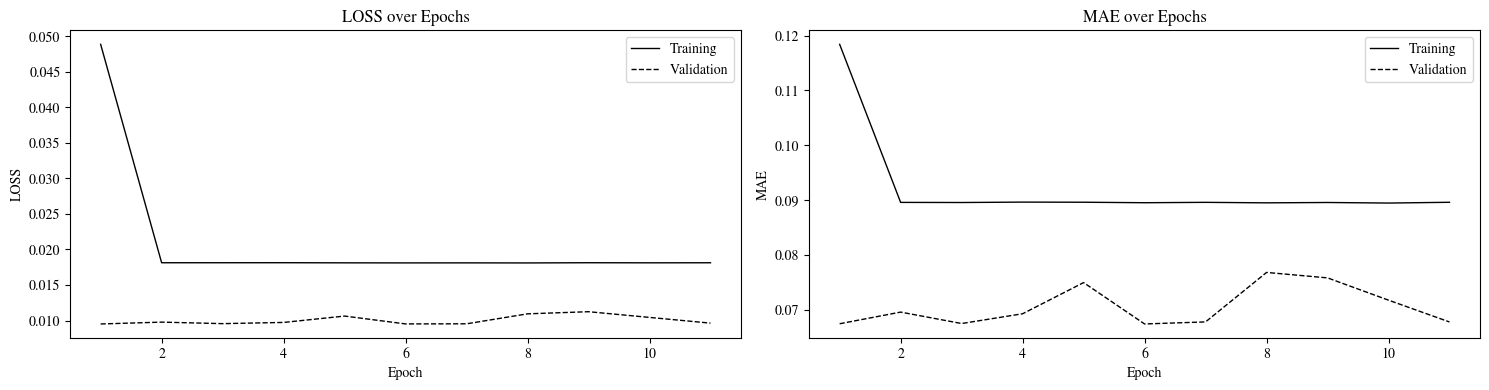

In [ ]:
# Plot the metrics for the final deep feedforward model
plot_metrics_side_by_side(dffn_history.history, metrics=['loss', 'mae'], figsize=(15, 4))


**Plot Analysis**

Loss Plot (MSE over Epochs)
- The training loss decreases smoothly, which indicates that the model is effectively learning from the data.
- The validation loss remains consistently lower than the training loss throughout the epochs. This is quite unusual because typically, validation loss is slightly higher or at least converges toward training loss.
- This behavior suggests that the model is generalizing well to the validation set, and there is no indication of overfitting.

MAE Plot (Mean Absolute Error over Epochs)
- The training MAE reduces steadily, showing the model's predictions are getting closer to the actual values as training progresses.
- The validation MAE fluctuates but remains generally lower than the training MAE.
- Small oscillations are present in the validation MAE, which is normal, especially with deeper networks that may be more sensitive to noise. However, it remains stable, and there is no indication of divergence from the training curve.

**Overfitting and Underfitting**

Validation loss does not diverge from training loss, and there is no sharp increase in validation error while training error decreases. Therefore, no overfitting seems to appear. If the model was underfitting, both training and validation errors would be high and plateau early. Here, both are steadily decreasing, suggesting the model is learning the relationships effectively.


In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


Both losses are low and flat, meaning model is not overfitting nor underfitting.
The validation loss remains stable and close to the training loss, which is good. Early stopping has likely halted training at ~12 epochs because no further improvement occurred. Both training and validation MAE are low (validation MAE ≈ 0.085). The validation MAE stays nearly flat, meaning the model does not degrade with more epochs.


| Metric                      | Deep FFNN |
| --------------------------- | --------- |
| **Test MSE**                | 0.01242   |
| **Test MAE**                | 0.07493   |
| Epochs until early stop     | 12        |
| Validation MSE (last epoch) | \~0.016   |
| Validation MAE (last epoch) | \~0.085   |
